In [1]:
# Import Global Dependencies
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch
import torch.nn.functional as F
# Import Helper Libaries
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import random
import copy
import time
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

CIFARtransform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

#### CNN Definition

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        # Output layer
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Convolutional layer 1 with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Convolutional layer 2 with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 4 * 4)
        # Fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Output layer with softmax activation
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [4]:
# Define the CNN model
class CIFARCNN(nn.Module):
    def __init__(self):
        super(CIFARCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 64)  # Assuming input size after max pooling is 4x4 and output size of dense layer is 64
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = self.pool(x)  
        x = F.relu(self.conv2(x))  
        x = self.pool(x)  
        x = F.relu(self.conv3(x))  
        x = self.pool(x)
        x = self.flatten(x)  # Flatten the output
        x = F.relu(self.fc1(x))  # Apply dense layer with relu activation
        x = self.fc2(x)  # Apply final dense layer
        return x

In [5]:
class SmallerCIFARCNN(nn.Module):
    def __init__(self):
        super(SmallerCIFARCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)  # Adjust the input size accordingly
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = self.pool(x)  
        x = F.relu(self.conv2(x))  
        x = self.pool(x)  
        x = x.view(-1, 32 * 8 * 8)  # Adjust the shape accordingly
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [6]:
def client_update(client_model, optimizer, train_loader, epochs):
    model.train()
    for i in range(epochs):
        for batch_index, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

In [7]:
def server_average(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
         global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
            
    global_model.load_state_dict(global_dict)
    
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [8]:
def test(global_model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = global_model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

In [9]:
def run_federated_learning_ABS(num_rounds, num_clients, num_selected, opt, train_loader, global_model, client_models, test_loader, epochs,client_age):
    IID_accuracy_list = []
    IID_avg_training_losses = []
    IID_eval_losses = []
    
    for r in range(num_rounds):   
        oldest_client_idx = np.argsort(client_age)[-num_selected:]
        # Update client age
        client_age += 1
        client_age[oldest_client_idx] = 0  # Reset age for selected client
        loss = 0
        # Go through the selected clients
        selected_model_list = []
        for i in range(num_selected):
            client_models[oldest_client_idx[i]].load_state_dict(global_model.state_dict())
            loss += client_update(client_models[oldest_client_idx[i]], opt[oldest_client_idx[i]], train_loader[oldest_client_idx[i]], epochs=epochs)
            selected_model_list.append(client_models[oldest_client_idx[i]])
        # serer aggregate
        server_average(global_model, selected_model_list)
        test_loss, acc = test(global_model, test_loader)
        IID_accuracy_list.append(acc)
        IID_eval_losses.append(test_loss)
        avg_training_loss = loss/ num_selected
        IID_avg_training_losses.append(avg_training_loss)    
        if(r % 10 == 0):
            print('%d-th round' % r)
            print('average train loss %0.3g | test loss %0.3g | test acc: %0.5f' % (avg_training_loss, test_loss, acc))

    return IID_accuracy_list, IID_avg_training_losses, IID_eval_losses


In [10]:
def run_federated_learning(num_rounds, num_clients, num_selected, opt, train_loader, global_model, client_models, test_loader, epochs):
    IID_accuracy_list = []
    IID_avg_training_losses = []
    IID_eval_losses = []
    for r in range(num_rounds):   
        client_idx = np.random.permutation(num_clients)[:num_selected]
        # client update
        loss = 0
        # Go through the selected clients
        selected_model_list = []
        for i in range(num_selected):
            client_models[client_idx[i]].load_state_dict(global_model.state_dict())
            loss += client_update(client_models[client_idx[i]], opt[client_idx[i]], train_loader[client_idx[i]], epochs=epochs)
            selected_model_list.append(client_models[client_idx[i]])
        # serer aggregate
        server_average(global_model, selected_model_list)
        test_loss, acc = test(global_model, test_loader)
        IID_accuracy_list.append(acc)
        IID_eval_losses.append(test_loss)
        avg_training_loss = loss/ num_selected
        IID_avg_training_losses.append(avg_training_loss)
        if(r % 10 == 0):
            print('%d-th round' % r)
            print('average train loss %0.3g | test loss %0.3g | test acc: %0.5f' % (avg_training_loss, test_loss, acc))

    return IID_accuracy_list, IID_avg_training_losses, IID_eval_losses


In [11]:
num_clients = 100 #Number of total clients
num_selected = 10 #Selection of clients
num_rounds = 150   # Number of rounds 
epochs = 5          #E epochs
batch_size = 50  # B mini batches

Files already downloaded and verified
0-th round
average train loss 2.25 | test loss 2.25 | test acc: 0.18160
10-th round
average train loss 1.2 | test loss 1.4 | test acc: 0.50500
20-th round
average train loss 0.258 | test loss 1.37 | test acc: 0.56810
30-th round
average train loss 0.0413 | test loss 1.4 | test acc: 0.60390
40-th round
average train loss 0.0256 | test loss 1.4 | test acc: 0.62260
50-th round
average train loss 0.034 | test loss 1.36 | test acc: 0.63560
60-th round
average train loss 0.0142 | test loss 1.36 | test acc: 0.64160
70-th round
average train loss 0.0118 | test loss 1.37 | test acc: 0.64500
80-th round
average train loss 0.0125 | test loss 1.35 | test acc: 0.65100
90-th round
average train loss 0.00812 | test loss 1.39 | test acc: 0.65080
100-th round
average train loss 0.00811 | test loss 1.42 | test acc: 0.65510
110-th round
average train loss 0.00784 | test loss 1.37 | test acc: 0.65450
120-th round
average train loss 0.00716 | test loss 1.4 | test acc: 

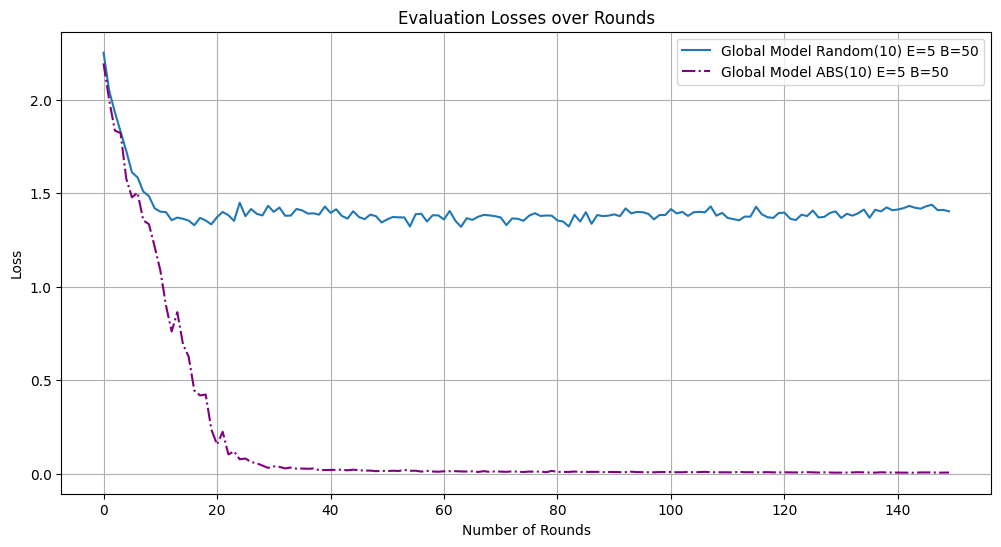

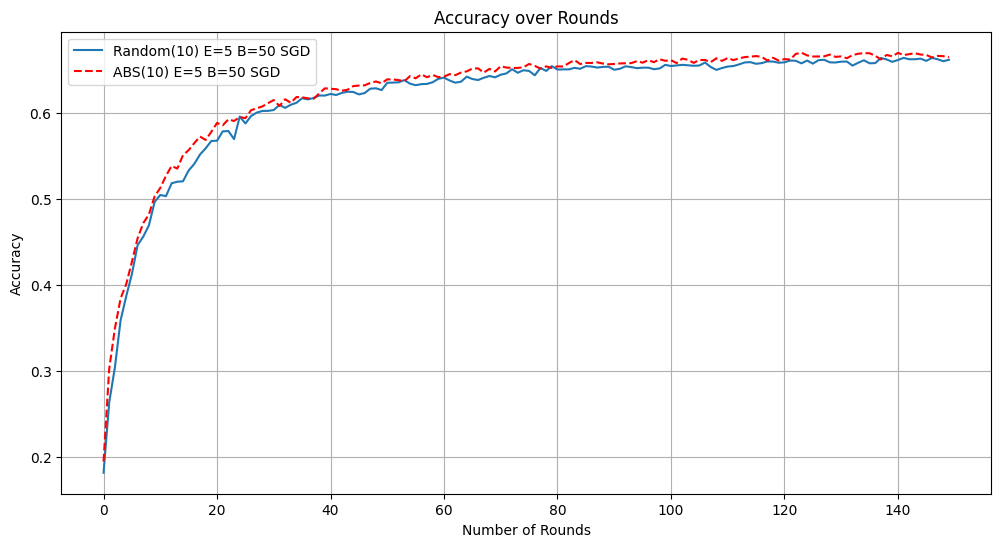

In [12]:
# Creating decentralized datasets

traindata = datasets.CIFAR10('./data', train=True, download=True, transform=CIFARtransform)

traindata_split = torch.utils.data.random_split(traindata, [len(traindata) // num_clients for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data', train=False, transform=CIFARtransform
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers

global_model = CIFARCNN().to(device)
client_models = [CIFARCNN().to(device) for _ in range(num_clients)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.15) for model in client_models]

# Add learning rate scheduler for each optimizer

# Runnining FL
IID_accuracy_list = []
IID_avg_training_losses = []
IID_eval_losses = []

IID_accuracy_list, IID_avg_training_losses, IID_eval_losses = run_federated_learning(num_rounds, num_clients, num_selected, 
                                                                                      opt, train_loader, global_model, 
                                                                                     client_models, test_loader, epochs) 

# Instantiate models and optimizers
global_model = CIFARCNN().to(device)
client_models = [CIFARCNN().to(device) for _ in range(num_clients)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.15) for model in client_models]
# Track the age of each client (number of rounds since last selection)
client_age = np.zeros(num_clients)

# Running FL
IID_aged_accuracy_list = []
IID_aged_avg_training_losses = []
IID_aged_eval_losses = []

IID_aged_accuracy_list, IID_aged_avg_training_losses, IID_aged_eval_losses = run_federated_learning_ABS(num_rounds, num_clients, num_selected, 
                                                                                     opt, train_loader, global_model, 
                                                                                     client_models, test_loader, 
                                                                                      epochs, client_age)

# global_model = CIFARCNN().to(device)
# client_models = [CIFARCNN().to(device) for _ in range(num_clients)]
# for model in client_models:
#     model.load_state_dict(global_model.state_dict())

# opt = [optim.Adam(model.parameters(), lr=0.0001) for model in client_models]

# # Runnining FL
# IID_Adam_accuracy_list = []
# IID_Adam_avg_training_losses = []
# IID_Adam_eval_losses = []

# IID_Adam_accuracy_list, IID_Adam_avg_training_losses, IID_Adam_eval_losses = run_federated_learning(num_rounds, num_clients, num_selected, 
#                                                                                       opt, train_loader, global_model, 
#                                                                                      client_models, test_loader, epochs)

# # Instantiate models and optimizers
# global_model = CIFARCNN().to(device)
# client_models = [CIFARCNN().to(device) for _ in range(num_clients)]
# for model in client_models:
#     model.load_state_dict(global_model.state_dict())

# opt = [optim.Adam(model.parameters(), lr=0.0001) for model in client_models]
# # Track the age of each client (number of rounds since last selection)
# client_age = np.zeros(num_clients)

# # Running FL
# IID_Adam_aged_accuracy_list = []
# IID_Adam_aged_avg_training_losses = []
# IID_Adam_aged_eval_losses = []

# IID_Adam_aged_accuracy_list, IID_Adam_aged_avg_training_losses, IID_Adam_aged_eval_losses = run_federated_learning_ABS(num_rounds, num_clients, num_selected, 
#                                                                                       opt, train_loader, global_model, 
#                                                                                      client_models, test_loader, 
#                                                                                       epochs, client_age)
# Save the global model


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_eval_losses, label=f'Global Model Random({num_selected}) E={epochs} B={batch_size}')
plt.plot(range(num_rounds), IID_aged_avg_training_losses, label=f'Global Model ABS({num_selected}) E={epochs} B={batch_size}', color='purple', linestyle='dashdot')
plt.xlabel('Number of Rounds')
plt.ylabel('Loss')
plt.title('Evaluation Losses over Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_accuracy_list, label=f'Random({num_selected}) E={epochs} B={batch_size} SGD')
plt.plot(range(num_rounds), IID_aged_accuracy_list, label=f'ABS({num_selected}) E={epochs} B={batch_size} SGD', color='red',linestyle='dashed')

plt.xlabel('Number of Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
num_clients = 100 #Number of total clients
num_selected = 5 #Selection of clients
num_rounds =150  # Number of rounds 
epochs = 5          #E epochs
batch_size = 50  # B mini batches

Files already downloaded and verified
0-th round
average train loss 2.19 | test loss 2.19 | test acc: 0.20260
10-th round
average train loss 1.1 | test loss 1.43 | test acc: 0.49660
20-th round
average train loss 0.218 | test loss 1.52 | test acc: 0.54930
30-th round
average train loss 0.0569 | test loss 1.49 | test acc: 0.58270
40-th round
average train loss 0.0399 | test loss 1.48 | test acc: 0.59210
50-th round
average train loss 0.0233 | test loss 1.51 | test acc: 0.60220
60-th round
average train loss 0.0158 | test loss 1.49 | test acc: 0.61150
70-th round
average train loss 0.0129 | test loss 1.54 | test acc: 0.62390
80-th round
average train loss 0.0108 | test loss 1.47 | test acc: 0.62860
90-th round
average train loss 0.0125 | test loss 1.47 | test acc: 0.62830
100-th round
average train loss 0.0193 | test loss 1.42 | test acc: 0.63840
110-th round
average train loss 0.011 | test loss 1.47 | test acc: 0.64260
120-th round
average train loss 0.0204 | test loss 1.44 | test acc: 

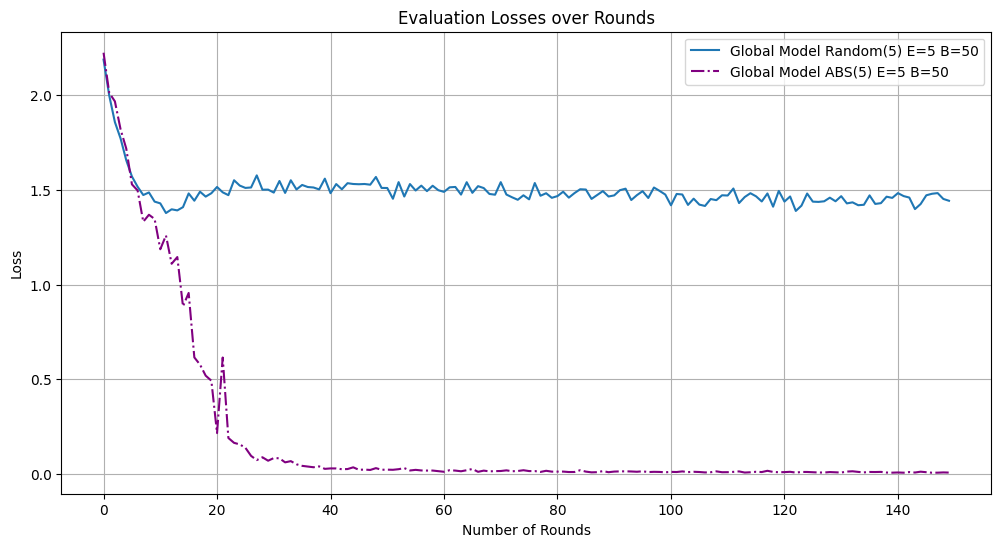

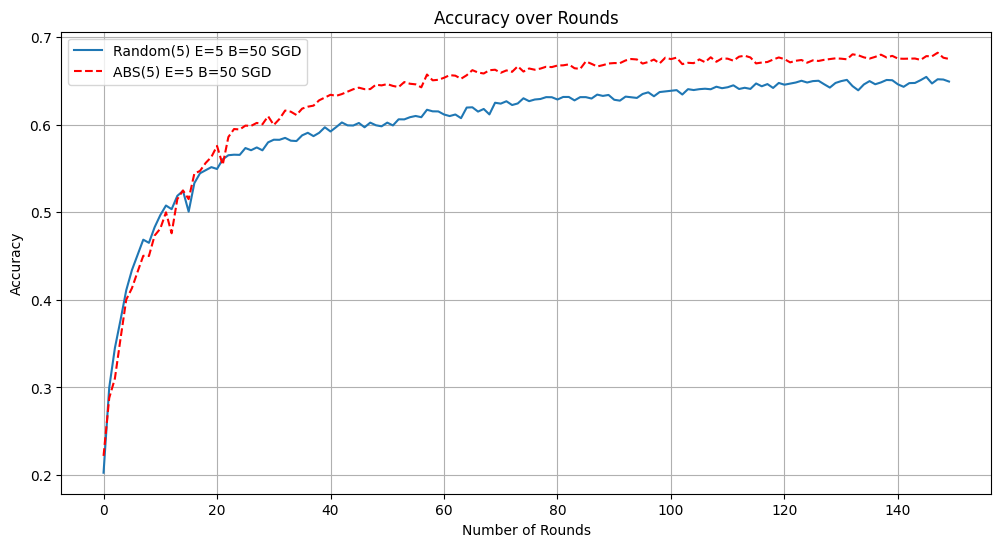

In [14]:
# Creating decentralized datasets

traindata = datasets.CIFAR10('./data', train=True, download=True, transform=CIFARtransform)

traindata_split = torch.utils.data.random_split(traindata, [len(traindata) // num_clients for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data', train=False, transform=CIFARtransform
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers

global_model = CIFARCNN().to(device)
client_models = [CIFARCNN().to(device) for _ in range(num_clients)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.15) for model in client_models]

# Add learning rate scheduler for each optimizer

# Runnining FL
IID_accuracy_list = []
IID_avg_training_losses = []
IID_eval_losses = []

IID_accuracy_list, IID_avg_training_losses, IID_eval_losses = run_federated_learning(num_rounds, num_clients, num_selected, 
                                                                                      opt, train_loader, global_model, 
                                                                                     client_models, test_loader, epochs) 

# Instantiate models and optimizers
global_model = CIFARCNN().to(device)
client_models = [CIFARCNN().to(device) for _ in range(num_clients)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.15) for model in client_models]
# Track the age of each client (number of rounds since last selection)
client_age = np.zeros(num_clients)

# Running FL
IID_aged_accuracy_list = []
IID_aged_avg_training_losses = []
IID_aged_eval_losses = []

IID_aged_accuracy_list, IID_aged_avg_training_losses, IID_aged_eval_losses = run_federated_learning_ABS(num_rounds, num_clients, num_selected, 
                                                                                     opt, train_loader, global_model, 
                                                                                     client_models, test_loader, 
                                                                                      epochs, client_age)

# global_model = CIFARCNN().to(device)
# client_models = [CIFARCNN().to(device) for _ in range(num_clients)]
# for model in client_models:
#     model.load_state_dict(global_model.state_dict())

# opt = [optim.Adam(model.parameters(), lr=0.0001) for model in client_models]

# # Runnining FL
# IID_Adam_accuracy_list = []
# IID_Adam_avg_training_losses = []
# IID_Adam_eval_losses = []

# IID_Adam_accuracy_list, IID_Adam_avg_training_losses, IID_Adam_eval_losses = run_federated_learning(num_rounds, num_clients, num_selected, 
#                                                                                       opt, train_loader, global_model, 
#                                                                                      client_models, test_loader, epochs)

# # Instantiate models and optimizers
# global_model = CIFARCNN().to(device)
# client_models = [CIFARCNN().to(device) for _ in range(num_clients)]
# for model in client_models:
#     model.load_state_dict(global_model.state_dict())

# opt = [optim.Adam(model.parameters(), lr=0.0001) for model in client_models]
# # Track the age of each client (number of rounds since last selection)
# client_age = np.zeros(num_clients)

# # Running FL
# IID_Adam_aged_accuracy_list = []
# IID_Adam_aged_avg_training_losses = []
# IID_Adam_aged_eval_losses = []

# IID_Adam_aged_accuracy_list, IID_Adam_aged_avg_training_losses, IID_Adam_aged_eval_losses = run_federated_learning_ABS(num_rounds, num_clients, num_selected, 
#                                                                                       opt, train_loader, global_model, 
#                                                                                      client_models, test_loader, 
#                                                                                       epochs, client_age)
# # Save the global model


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_eval_losses, label=f'Global Model Random({num_selected}) E={epochs} B={batch_size}')
plt.plot(range(num_rounds), IID_aged_avg_training_losses, label=f'Global Model ABS({num_selected}) E={epochs} B={batch_size}', color='purple', linestyle='dashdot')
plt.xlabel('Number of Rounds')
plt.ylabel('Loss')
plt.title('Evaluation Losses over Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_accuracy_list, label=f'Random({num_selected}) E={epochs} B={batch_size} SGD')
plt.plot(range(num_rounds), IID_aged_accuracy_list, label=f'ABS({num_selected}) E={epochs} B={batch_size} SGD', color='red',linestyle='dashed')

plt.xlabel('Number of Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
num_clients = 100 #Number of total clients
num_selected = 10 #Selection of clients
num_rounds = 150   # Number of rounds 
epochs = 5          #E epochs
batch_size = 50  # B mini batches

Files already downloaded and verified
0-th round
average train loss 2.03 | test loss 2 | test acc: 0.31460
10-th round
average train loss 0.543 | test loss 1.41 | test acc: 0.53070
20-th round
average train loss 0.0615 | test loss 1.47 | test acc: 0.56260
30-th round
average train loss 0.0329 | test loss 1.47 | test acc: 0.58780
40-th round
average train loss 0.0289 | test loss 1.47 | test acc: 0.60260
50-th round
average train loss 0.0198 | test loss 1.43 | test acc: 0.60840
60-th round
average train loss 0.0145 | test loss 1.45 | test acc: 0.61710
70-th round
average train loss 0.0139 | test loss 1.45 | test acc: 0.61910
80-th round
average train loss 0.0083 | test loss 1.49 | test acc: 0.62270
90-th round
average train loss 0.0109 | test loss 1.49 | test acc: 0.61970
100-th round
average train loss 0.0065 | test loss 1.5 | test acc: 0.62620
110-th round
average train loss 0.00706 | test loss 1.54 | test acc: 0.63000
120-th round
average train loss 0.00638 | test loss 1.58 | test acc

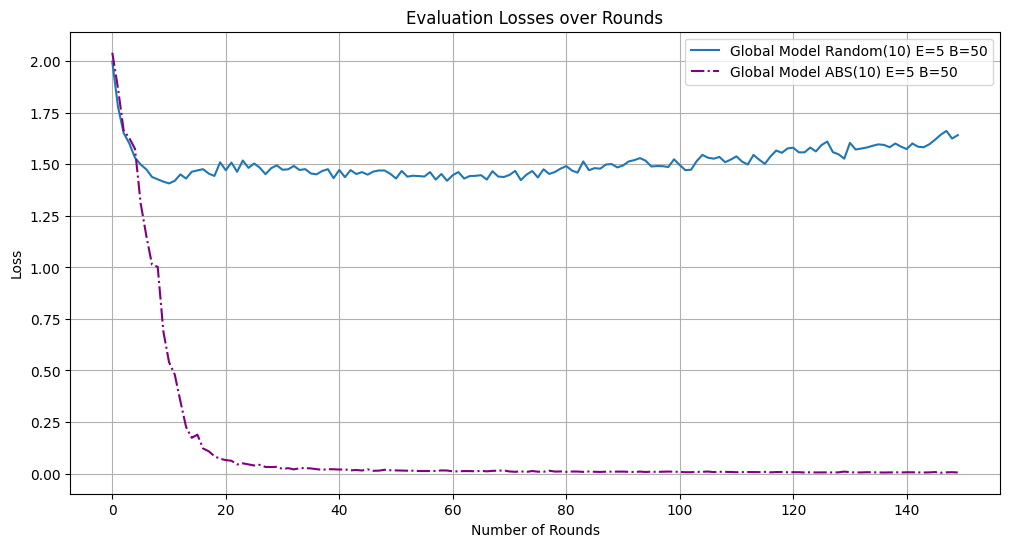

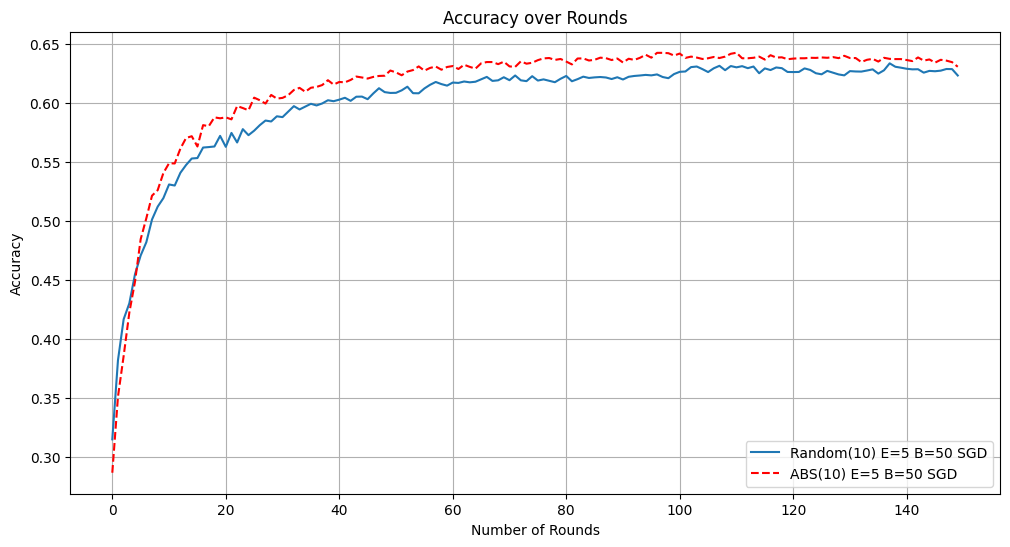

In [16]:
# Creating decentralized datasets

traindata = datasets.CIFAR10('./data', train=True, download=True, transform=CIFARtransform)

traindata_split = torch.utils.data.random_split(traindata, [len(traindata) // num_clients for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data', train=False, transform=CIFARtransform
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers

global_model = SmallerCIFARCNN().to(device)
client_models = [SmallerCIFARCNN().to(device) for _ in range(num_clients)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.15) for model in client_models]

# Add learning rate scheduler for each optimizer

# Runnining FL
IID_accuracy_list = []
IID_avg_training_losses = []
IID_eval_losses = []

IID_accuracy_list, IID_avg_training_losses, IID_eval_losses = run_federated_learning(num_rounds, num_clients, num_selected, 
                                                                                      opt, train_loader, global_model, 
                                                                                     client_models, test_loader, epochs) 

# Instantiate models and optimizers
global_model = SmallerCIFARCNN().to(device)
client_models = [SmallerCIFARCNN().to(device) for _ in range(num_clients)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.15) for model in client_models]
# Track the age of each client (number of rounds since last selection)
client_age = np.zeros(num_clients)

# Running FL
IID_aged_accuracy_list = []
IID_aged_avg_training_losses = []
IID_aged_eval_losses = []

IID_aged_accuracy_list, IID_aged_avg_training_losses, IID_aged_eval_losses = run_federated_learning_ABS(num_rounds, num_clients, num_selected, 
                                                                                     opt, train_loader, global_model, 
                                                                                     client_models, test_loader, 
                                                                                      epochs, client_age)

# global_model = SmallerCIFARCNN().to(device)
# client_models = [SmallerCIFARCNN().to(device) for _ in range(num_clients)]
# for model in client_models:
#     model.load_state_dict(global_model.state_dict())

# opt = [optim.Adam(model.parameters(), lr=0.0001) for model in client_models]

# # Runnining FL
# IID_Adam_accuracy_list = []
# IID_Adam_avg_training_losses = []
# IID_Adam_eval_losses = []

# IID_Adam_accuracy_list, IID_Adam_avg_training_losses, IID_Adam_eval_losses = run_federated_learning(num_rounds, num_clients, num_selected, 
#                                                                                       opt, train_loader, global_model, 
#                                                                                      client_models, test_loader, epochs)

# # Instantiate models and optimizers
# global_model = SmallerCIFARCNN().to(device)
# client_models = [SmallerCIFARCNN().to(device) for _ in range(num_clients)]
# for model in client_models:
#     model.load_state_dict(global_model.state_dict())

# opt = [optim.Adam(model.parameters(), lr=0.0001) for model in client_models]
# # Track the age of each client (number of rounds since last selection)
# client_age = np.zeros(num_clients)

# # Running FL
# IID_Adam_aged_accuracy_list = []
# IID_Adam_aged_avg_training_losses = []
# IID_Adam_aged_eval_losses = []

# IID_Adam_aged_accuracy_list, IID_Adam_aged_avg_training_losses, IID_Adam_aged_eval_losses = run_federated_learning_ABS(num_rounds, num_clients, num_selected, 
#                                                                                       opt, train_loader, global_model, 
#                                                                                      client_models, test_loader, 
#                                                                                       epochs, client_age)
# # Save the global model


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_eval_losses, label=f'Global Model Random({num_selected}) E={epochs} B={batch_size}')
plt.plot(range(num_rounds), IID_aged_avg_training_losses, label=f'Global Model ABS({num_selected}) E={epochs} B={batch_size}', color='purple', linestyle='dashdot')
plt.xlabel('Number of Rounds')
plt.ylabel('Loss')
plt.title('Evaluation Losses over Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_accuracy_list, label=f'Random({num_selected}) E={epochs} B={batch_size} SGD')
plt.plot(range(num_rounds), IID_aged_accuracy_list, label=f'ABS({num_selected}) E={epochs} B={batch_size} SGD', color='red',linestyle='dashed')

plt.xlabel('Number of Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
num_clients = 100 #Number of total clients
num_selected = 5 #Selection of clients
num_rounds = 150   # Number of rounds 
epochs = 5          #E epochs
batch_size = 50  # B mini batches

Files already downloaded and verified
0-th round
average train loss 2 | test loss 2.04 | test acc: 0.27020
10-th round
average train loss 0.506 | test loss 1.47 | test acc: 0.51550
20-th round
average train loss 0.0659 | test loss 1.59 | test acc: 0.54890
30-th round
average train loss 0.0636 | test loss 1.58 | test acc: 0.57190
40-th round
average train loss 0.0307 | test loss 1.53 | test acc: 0.58940
50-th round
average train loss 0.0204 | test loss 1.53 | test acc: 0.59550
60-th round
average train loss 0.0144 | test loss 1.58 | test acc: 0.60120
70-th round
average train loss 0.021 | test loss 1.57 | test acc: 0.60350
80-th round
average train loss 0.0168 | test loss 1.49 | test acc: 0.61290
90-th round
average train loss 0.0218 | test loss 1.52 | test acc: 0.61660
100-th round
average train loss 0.0121 | test loss 1.57 | test acc: 0.61600
110-th round
average train loss 0.0103 | test loss 1.59 | test acc: 0.61690
120-th round
average train loss 0.0126 | test loss 1.6 | test acc: 0

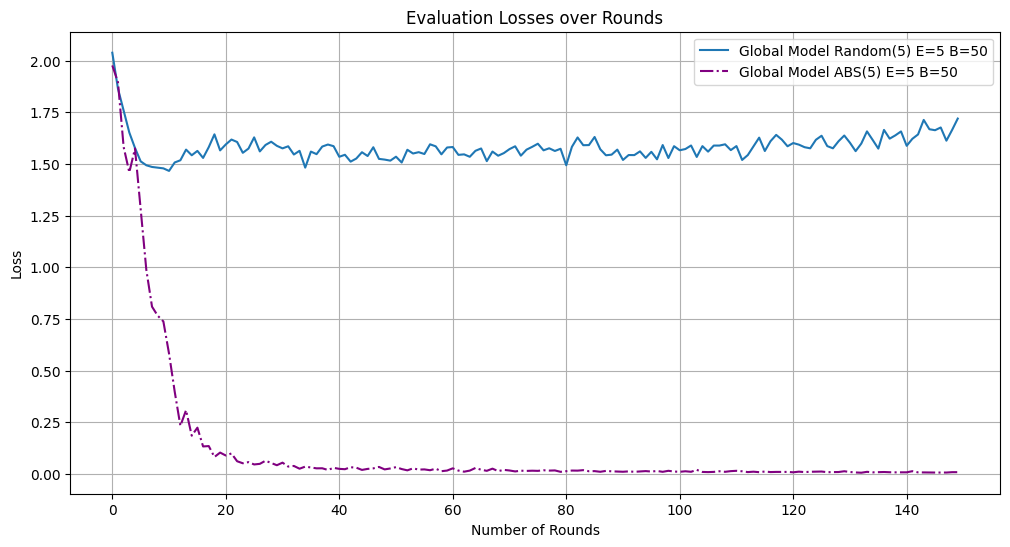

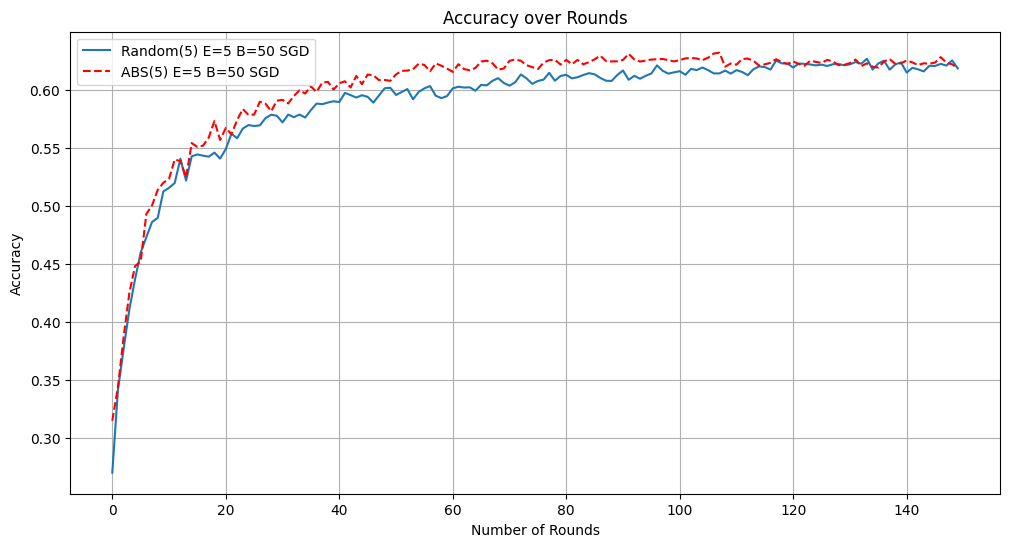

In [18]:
# Creating decentralized datasets
traindata = datasets.CIFAR10('./data', train=True, download=True, transform=CIFARtransform)

traindata_split = torch.utils.data.random_split(traindata, [len(traindata) // num_clients for _ in range(num_clients)])
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data', train=False, transform=CIFARtransform
        ), batch_size=batch_size, shuffle=True)

# Instantiate models and optimizers

global_model = SmallerCIFARCNN().to(device)
client_models = [SmallerCIFARCNN().to(device) for _ in range(num_clients)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.15) for model in client_models]

# Add learning rate scheduler for each optimizer

# Runnining FL
IID_accuracy_list = []
IID_avg_training_losses = []
IID_eval_losses = []

IID_accuracy_list, IID_avg_training_losses, IID_eval_losses = run_federated_learning(num_rounds, num_clients, num_selected, 
                                                                                      opt, train_loader, global_model, 
                                                                                     client_models, test_loader, epochs) 

# Instantiate models and optimizers
global_model = SmallerCIFARCNN().to(device)
client_models = [SmallerCIFARCNN().to(device) for _ in range(num_clients)]
for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [optim.SGD(model.parameters(), lr=0.15) for model in client_models]
# Track the age of each client (number of rounds since last selection)
client_age = np.zeros(num_clients)

# Running FL
IID_aged_accuracy_list = []
IID_aged_avg_training_losses = []
IID_aged_eval_losses = []

IID_aged_accuracy_list, IID_aged_avg_training_losses, IID_aged_eval_losses = run_federated_learning_ABS(num_rounds, num_clients, num_selected, 
                                                                                     opt, train_loader, global_model, 
                                                                                     client_models, test_loader, 
                                                                                      epochs, client_age)

# global_model = SmallerCIFARCNN().to(device)
# client_models = [SmallerCIFARCNN().to(device) for _ in range(num_clients)]
# for model in client_models:
#     model.load_state_dict(global_model.state_dict())

# opt = [optim.Adam(model.parameters(), lr=0.0001) for model in client_models]

# # Runnining FL
# IID_Adam_accuracy_list = []
# IID_Adam_avg_training_losses = []
# IID_Adam_eval_losses = []

# IID_Adam_accuracy_list, IID_Adam_avg_training_losses, IID_Adam_eval_losses = run_federated_learning(num_rounds, num_clients, num_selected, 
#                                                                                       opt, train_loader, global_model, 
#                                                                                      client_models, test_loader, epochs)

# # Instantiate models and optimizers
# global_model = SmallerCIFARCNN().to(device)
# client_models = [SmallerCIFARCNN().to(device) for _ in range(num_clients)]
# for model in client_models:
#     model.load_state_dict(global_model.state_dict())

# opt = [optim.Adam(model.parameters(), lr=0.0001) for model in client_models]
# # Track the age of each client (number of rounds since last selection)
# client_age = np.zeros(num_clients)

# # Running FL
# IID_Adam_aged_accuracy_list = []
# IID_Adam_aged_avg_training_losses = []
# IID_Adam_aged_eval_losses = []

# IID_Adam_aged_accuracy_list, IID_Adam_aged_avg_training_losses, IID_Adam_aged_eval_losses = run_federated_learning_ABS(num_rounds, num_clients, num_selected, 
#                                                                                       opt, train_loader, global_model, 
#                                                                                      client_models, test_loader, 
#                                                                                       epochs, client_age)
# Save the global model
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_eval_losses, label=f'Global Model Random({num_selected}) E={epochs} B={batch_size}')
plt.plot(range(num_rounds), IID_aged_avg_training_losses, label=f'Global Model ABS({num_selected}) E={epochs} B={batch_size}', color='purple', linestyle='dashdot')
plt.xlabel('Number of Rounds')
plt.ylabel('Loss')
plt.title('Evaluation Losses over Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(num_rounds), IID_accuracy_list, label=f'Random({num_selected}) E={epochs} B={batch_size} SGD')
plt.plot(range(num_rounds), IID_aged_accuracy_list, label=f'ABS({num_selected}) E={epochs} B={batch_size} SGD', color='red',linestyle='dashed')

plt.xlabel('Number of Rounds')
plt.ylabel('Accuracy')
plt.title('Accuracy over Rounds')
plt.legend()
plt.grid(True)
plt.show()